In [1]:
!pip install git+https://github.com/allegroai/clearml
!pip install clearml-agent

  Cloning https://github.com/allegroai/clearml to /tmp/pip-req-build-b9vw65h7
  Running command git clone --filter=blob:none --quiet https://github.com/allegroai/clearml /tmp/pip-req-build-b9vw65h7
  Resolved https://github.com/allegroai/clearml to commit 54418060ae94179a35bfef00c83c292ebfa5f13d
  Preparing metadata (setup.py) ... done
  Created wheel for clearml: filename=clearml-1.16.1-py2.py3-none-any.whl size=1149744 sha256=1e24ae5ce07efb5000c123f4b737a48e66b7fea1c53c9efe6df9a229252c9280
  Stored in directory: /tmp/pip-ephem-wheel-cache-klihcdrf/wheels/c3/cb/b6/3cbc932bc45b51ba5c2a0c14d9db80499ad5f6869fe8b26a7d
Successfully built clearml
  Attempting uninstall: pyjwt
    Found existing installation: PyJWT 2.3.0
    Uninstalling PyJWT-2.3.0:
      Successfully uninstalled PyJWT-2.3.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 430.7/430.7 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
! export MPLBACKEND=TkAg

In [3]:
from clearml import Task

Task.set_credentials(
     api_host="https://api.clear.ml",
     web_host="https://app.clear.ml",
     files_host="https://files.clear.ml",
     key="N413BNTFNXYKVDSNUM83",
     secret='wzEwbgcKlUu8jHUflhBh5aaeIQKsLbFWykbDogDpFSODQLQHZd'
)

In [4]:
import joblib
import polars as pl
from clearml import Dataset, Task

import os
import polars as pl
from sklearn.model_selection import train_test_split
import torch
from transformers import AutoModel, AutoTokenizer
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

import pickle

In [5]:
TASK_NAME = "Bert model in Colab"

In [6]:
from clearml import Dataset, Task
# init task
task = Task.init(project_name="Toxic comments", task_name=TASK_NAME, output_uri=True)

# get local copy of dataset
dataset = Dataset.get(
    dataset_project="Toxic comments", dataset_name="Raw data",

).get_local_copy()

task.set_progress(0)

ClearML Task: created new task id=a361657b6f33456299377c00e725b791
2024-05-25 08:31:31,719 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/ad182336b7f24902a01fce478ef1d156/experiments/a361657b6f33456299377c00e725b791/output/log


/usr/local/lib/python3.10/dist-packages/clearml/utilities/process/mp.py:622: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



2024-05-25 08:31:43,421 - clearml - INFO - Dataset.get() did not specify alias. Dataset information will not be automatically logged in ClearML Server.
2024-05-25 08:32:00,827 - clearml.storage - INFO - Downloading: 24.63MB from https://files.clear.ml/Toxic%20comments/.datasets/Raw%20data/Raw%20data.dab08a13e2f842a2967a824045c374ad/artifacts/data/dataset.dab08a13e2f842a2967a824045c374ad.cm0t9fmj.zip


███████████████████████████████ 100% | 24.63/24.63 MB [00:01<00:00, 15.34MB/s]: /usr/local/lib/python3.10/dist-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

███████████████████ 100% | 24.63000751495361/24.63 MB [00:01<00:00, 17.05MB/s]: 

2024-05-25 08:32:02,283 - clearml.storage - INFO - Downloaded 24.63 MB successfully from https://files.clear.ml/Toxic%20comments/.datasets/Raw%20data/Raw%20data.dab08a13e2f842a2967a824045c374ad/artifacts/data/dataset.dab08a13e2f842a2967a824045c374ad.cm0t9fmj.zip , saved to /root/.clearml/cache/storage_manager/datasets/04a9438499dea9fb996ee78849e59a9b.dataset.dab08a13e2f842a2967a824045c374ad.cm0t9fmj.zip


2024-05-25 08:32:02,757 - clearml - INFO - Dataset.get() did not specify alias. Dataset information will not be automatically logged in ClearML Server.


In [7]:
# loading dataset
data = pl.read_csv(
    os.path.join(dataset, "toxic_comments.csv"),
    has_header=False,
    new_columns=["id", "text", "toxic"],
    n_rows=50000,
)

pl.Config.set_fmt_str_lengths(100)
data.head()

id,text,toxic
i64,str,str
null,"""text""","""toxic"""
0,"""Explanation Why the edits made under my username Hardcore Metallica Fan were reverted? They weren'…","""0"""
1,"""D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 1…","""0"""
2,"""Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant…","""0"""
3,""""" More I can't make any real suggestions on improvement - I wondered if the section statistics sh…","""0"""


In [8]:
task.set_progress(10)

In [9]:
data["toxic"].value_counts()

toxic,count
str,u32
"""0""",44852
"""toxic""",1
"""1""",5147


In [10]:
train, test = train_test_split(
    data,
    test_size=0.2,
    random_state=42,
    shuffle=False
)

In [11]:
def get_device():
    # Если в системе есть GPU ...
    if torch.cuda.is_available():
        # Тогда говорим PyTorch использовать GPU.
        device = torch.device("cuda")
        print("There are %d GPU(s) available." % torch.cuda.device_count())
        print("We will use the GPU:", torch.cuda.get_device_name(0))
    # Если нет GPU, то считаем на обычном процессоре ...
    else:
        print("No GPU available, using the CPU instead.")
        device = torch.device("cpu")
    return device


device = get_device()

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [12]:
# initialize BERT model
model_name = "bert-base-uncased"
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [13]:
from torch.utils.data import DataLoader

batch_size = 128
train_dataloader = DataLoader(train["text"].to_list(), batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test["text"].to_list(), batch_size=batch_size, shuffle=False)

In [14]:
# Fix progress in clearml
task.set_progress(20)


In [15]:
def batch_inference(batch):
    tokenized_batch = tokenizer(batch, padding=True, truncation=True, return_tensors="pt").to(
        device
    )
    with torch.no_grad():
        hidden_batch = bert_model(**tokenized_batch)
        batch_embeddings = hidden_batch.last_hidden_state[:, 0, :].detach().to("cpu")
        return batch_embeddings


train_embeddings = torch.concat([batch_inference(batch_data) for batch_data in train_dataloader])


test_embeddings = torch.concat([batch_inference(batch_data) for batch_data in test_dataloader])

In [ ]:
task.set_progress(85)

task.upload_artifact(name="train_embeddings", artifact_object=train_embeddings)


task.upload_artifact(name="test_embeddings", artifact_object=test_embeddings)

True

 Training model of logistic regression on embeddings taking from bert

In [16]:
model_params = {
    "random_state": 42,
    "multi_class": "multinomial",
    "solver": "saga",
}

task.connect(model_params)

model_lr = LogisticRegression(**model_params)
model_lr.fit(train_embeddings, train["toxic"])


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



LogisticRegression(multi_class='multinomial', random_state=42, solver='saga')

In [19]:
task.set_progress(80)
task.upload_artifact(
    name='LogisticRegression',
    artifact_object=pickle.dumps(model_lr)
)

True

In [22]:
predicts = model_lr.predict(test_embeddings)

report = classification_report(test["toxic"], predicts, output_dict=True)


# building confusion matrix
conf_matrix = confusion_matrix(test["toxic"], predicts)


In [23]:
# Fix progress in CLearML
task.set_progress(95)

# Fix parameters of model
logger = task.get_logger()

logger.report_single_value("Accuracy", report.pop("accuracy"))

for class_name, metrics in report.items():
    for metric, value in metrics.items():
        logger.report_single_value(f"{class_name}_{metric}", value)

logger.report_confusion_matrix("Confusion matrix", "ignored", matrix=conf_matrix)

In [24]:
task.close()

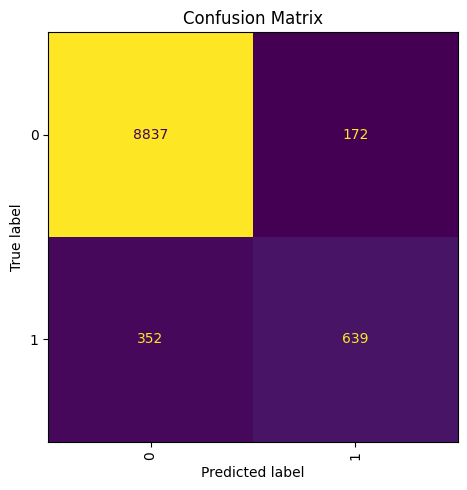

In [26]:
%matplotlib inline


fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_predictions(test["toxic"], predicts, ax=ax, colorbar=False)
ax.xaxis.set_tick_params(rotation=90)
_ = ax.set_title("Confusion Matrix")
plt.tight_layout()
